In [23]:
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization)
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

## I. Reading the dataset
The dataset is splitted into the training dataset and the validation dataset. There are 882 images in the training dataset while there are 325 images in the validation one. There are six labels in the data:
- Fresh apple 
- Fresh banana
- Fresh oranges
- Rotten apple
- Rotten banana
- Rotten orange

The task is to import these images and labels from the folder to prepare to train the data. 

In [24]:
train_path = '/content/drive/MyDrive/Fruits/Train'
valid_path = '/content/drive/MyDrive/Fruits/Valid'

In [25]:
def read_img(path):
  x = []
  y = []
  for folder in os.listdir(path):
    #get the path of each sub-category
    sub_path=path+"/"+folder
    for img in os.listdir(sub_path):
      #get the path of each image
      image_path=sub_path+"/"+img
      x.append(image_path)
      y.append(folder)

  df = pd.DataFrame({'img':x, 'label':y})
  return df

In [26]:
train_df = read_img(train_path)
valid_df = read_img(valid_path)

In [27]:
train_df

,img,label
0,/content/drive/MyDrive/Fruits/Train/rottenoran...,rottenoranges
1,/content/drive/MyDrive/Fruits/Train/rottenoran...,rottenoranges
2,/content/drive/MyDrive/Fruits/Train/rottenoran...,rottenoranges
3,/content/drive/MyDrive/Fruits/Train/rottenoran...,rottenoranges
4,/content/drive/MyDrive/Fruits/Train/rottenoran...,rottenoranges
...,...,...
877,/content/drive/MyDrive/Fruits/Train/freshapple...,freshapples
878,/content/drive/MyDrive/Fruits/Train/freshapple...,freshapples
879,/content/drive/MyDrive/Fruits/Train/freshapple...,freshapples
880,/content/drive/MyDrive/Fruits/Train/freshapple...,freshapples


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


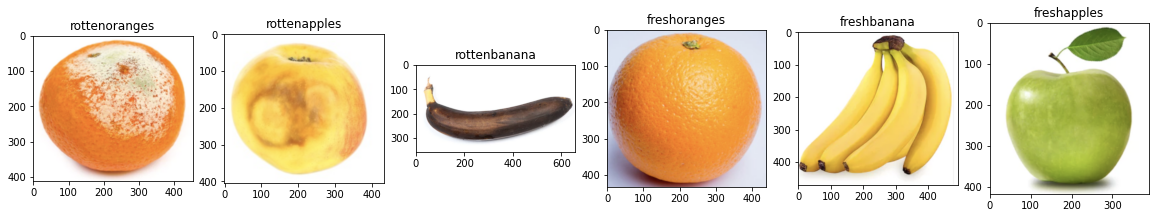

In [29]:
fig, ax = plt.subplots(ncols=6, figsize=(20,4))
random_num = 12
label_list = list(train_df['label'].unique())
for i, label in enumerate(label_list):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(train_df[train_df['label']==label]['img'].iloc[random_num]))


## II. Process the image

### a. Encode the label

There is two popular types of categorical encoding: label (ordinal) encoding and one-hot encoding. Because our categorical data is not ordinal, and the number of value is not too many (6 labels), so one-hot encoding is better, result in faster traning and effective result.

In [30]:
def encode_label(df):
  df_labels = {
    'rottenoranges' : 0,
    'rottenapples' : 1,
    'rottenbanana' : 2,
    'freshoranges' : 3,
    'freshbanana': 4,
    'freshapples': 5,}

  df['label'] = df['label'].map(df_labels)
  y = df['label']
  y = keras.utils.to_categorical(y, 6)
  return y


In [31]:
train_y = encode_label(train_df)
valid_y = encode_label(valid_df)

In [32]:
print(train_y)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


### b. Process the image

To fit the image into our model, each image is processed in the following step:

1. Convert the image into an array. Each value in this array represents for the brightness of a pixel in that image.
2. Resize the image to 224x224. This is one of the standard size for images in a neural netork model. This transforms the size of every image to the same size to fit into the model.
3. The value of each pixel will vary from 0 to 255. It is ineffective for the model to train. Therefore, we normalize these values by dividing those by 255 to get the value with the range of 0-1.



In [33]:
def process_each(path):
  img=cv2.imread(path)
  img=cv2.resize(img,(224,224))
  img = img/255
  return img

def process_img(df):
  X = []
  for img in df['img']:
      img_arr = process_each(img)
      X.append(img_arr)
  return np.array(X)

In [34]:
train_x = process_img(train_df)
valid_x = process_img(valid_df)

The result is an array containing the pixel information of every image. The training data has 882 images, each image is interpreted in 224x224 value, and 3 color channels. The validation data has 325 images, each image has 224x224x3 pixels.

In [35]:
print(train_x.shape)
print(valid_x.shape)

(882, 224, 224, 3)
(325, 224, 224, 3)


### III. Train the model

The idea of building the model is to start from simple model and then address problems of this model by adjusting hyperparameters, augmenting more data and increasing the complexity of the model. As the result, the final model should achieve a high accuracy in both training and validation dataset. This project assumes the performance baseline is 90% accuracy - which means the model producing 9 out of 10 predictions is acceptable.

In [36]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False
)  

img_iter = datagen.flow(train_x, train_y, batch_size=8)

In [46]:
model = Sequential(
    [
        Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
        MaxPool2D((2,2), strides=2, padding='same'),
        Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
        MaxPool2D((2,2), strides=2, padding='same'),
        Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ]
)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(img_iter, epochs=150, steps_per_epoch=len(img_iter)/8, validation_data=(valid_x, valid_y))

Epoch 1/150
13/13 [==============================] - 4s 256ms/step - loss: 1.7458 - accuracy: 0.2679 - val_loss: 1.9156 - val_accuracy: 0.4708
Epoch 2/150
13/13 [==============================] - 2s 174ms/step - loss: 1.3919 - accuracy: 0.4554 - val_loss: 1.8017 - val_accuracy: 0.4554
Epoch 3/150
13/13 [==============================] - 2s 175ms/step - loss: 1.2318 - accuracy: 0.5625 - val_loss: 1.6510 - val_accuracy: 0.4585
Epoch 4/150
13/13 [==============================] - 2s 174ms/step - loss: 1.2030 - accuracy: 0.6071 - val_loss: 1.5528 - val_accuracy: 0.5231
Epoch 5/150
13/13 [==============================] - 2s 175ms/step - loss: 1.1414 - accuracy: 0.5804 - val_loss: 1.7713 - val_accuracy: 0.4277
Epoch 6/150
13/13 [==============================] - 2s 175ms/step - loss: 1.2065 - accuracy: 0.5714 - val_loss: 1.2618 - val_accuracy: 0.5415
Epoch 7/150
13/13 [==============================] - 2s 174ms/step - loss: 0.8632 - accuracy: 0.6887 - val_loss: 1.2100 - val_accuracy: 0.4092

The result implies that data augmentation does not boost the performance of the model. Therefore, the only reason for this overfitting is that the model is too simple so that it can not capture important features of the dataset. However, we will still apply data augmentation in the next models as it theoretically improve the performance of any model (since our dataset does not have much data)

### c. Transfer Learning

##### **VGG16**

VGG16 is the neural network architecture that have 16 weighted layers used to  classify images into 1000 object categories. After loading the model, we specify the datashape of the input, add global average pooling layer and adjust the output layer into 6 categories. 

In [38]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(6, activation = 'softmax')(x)
vgg16 = keras.Model(inputs, outputs)

In [39]:
vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


Model.trainable=True allows the model to adjust the weights of the orginal model to suit with the dataset. The chosen optimizer is Gradient Descent with Momentum to ensure the model will be convergent at the minimum lost and boost the performance of the model.

In [16]:
vgg16.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
vgg16.fit(img_iter, epochs=150, validation_data=(valid_x, valid_y))

Epoch 1/150
111/111 [==============================] - 18s 150ms/step - loss: 1.4910 - accuracy: 0.5227 - val_loss: 1.5707 - val_accuracy: 0.5815
Epoch 2/150
111/111 [==============================] - 12s 105ms/step - loss: 1.0871 - accuracy: 0.7834 - val_loss: 1.2473 - val_accuracy: 0.6462
Epoch 3/150
111/111 [==============================] - 12s 104ms/step - loss: 0.8571 - accuracy: 0.8549 - val_loss: 1.0241 - val_accuracy: 0.6646
Epoch 4/150
111/111 [==============================] - 12s 104ms/step - loss: 0.7118 - accuracy: 0.8617 - val_loss: 0.9578 - val_accuracy: 0.6892
Epoch 5/150
111/111 [==============================] - 12s 105ms/step - loss: 0.6091 - accuracy: 0.8776 - val_loss: 0.8143 - val_accuracy: 0.7138
Epoch 6/150
111/111 [==============================] - 12s 105ms/step - loss: 0.5378 - accuracy: 0.8957 - val_loss: 0.8297 - val_accuracy: 0.6954
Epoch 7/150
111/111 [==============================] - 12s 105ms/step - loss: 0.4832 - accuracy: 0.8866 - val_loss: 0.6934 -

The model performs well on both training and validation dataset. The result exceeds the performance baseline, therefore, this model is suitable for this task and can be used to predict other images.

### IV. Evaluate the model (VGG16 vs ResNet50)

The VGG16 and ResNet50 both shows a good performance on the training and validation dataset. However, to further evaluate the effectiveness of the model, k-fold cross validation is applied.

This evaluation is tested on an unseen data collected from the Internet including 10 images of each category.

**Prepare the testing data**

In [17]:
test_path = '/content/drive/MyDrive/Fruits/Test'
test_df = read_img(test_path)
test_y = encode_label(test_df)
test_x = process_img(test_df)

**Performance on the testing dataset**

In [47]:
model_r = model.evaluate(test_x, test_y)
print('The accuracy of the VGG16 model is: ', model_r[1])

2/2 [==============================] - 0s 114ms/step - loss: 2.3325 - accuracy: 0.6087
The accuracy of the VGG16 model is:  0.6086956262588501


In [19]:
vgg16_r = vgg16.evaluate(test_x, test_y)
print('The accuracy of the VGG16 model is: ', vgg16_r[1])

2/2 [==============================] - 0s 83ms/step - loss: 0.4769 - accuracy: 0.8478
The accuracy of the VGG16 model is:  0.8478260636329651


As the result implies that the performance of VGG16 is better than ResNet50 - it exceeds the performance baseline.

### IV. Predict the model

The testing dataset is also used to make some predictions as example.

In [20]:
img_list = read_img(test_path)

In [21]:
def get_result(x):
  index = x.argmax()
  labels = ['rottenoranges', 'rottenapples','rottenbanana','freshoranges','freshbanana','freshapples']
  return labels[index]

1/1 [==============================] - 1s 1s/step


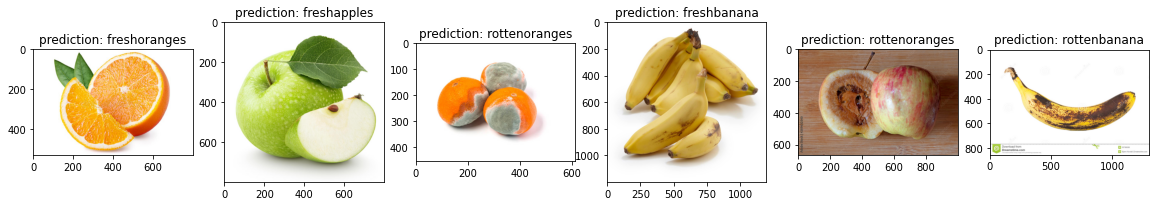

In [22]:
fig, ax = plt.subplots(ncols=6, figsize=(20,4))
random_num = 5
label_list = img_list['label'].unique()

example = []
for label in label_list:
  img = img_list[img_list['label']==label]['img'].iloc[random_num]
  example.append(process_each(img))

prediction = list(vgg16.predict(np.array(example)))

for i, label in enumerate(label_list):
    y_hat = get_result(prediction[i])
    t = 'prediction: ' + y_hat
    ax[i].set_title(t)
    ax[i].imshow(plt.imread(img_list[img_list['label']==label]['img'].iloc[random_num]))

### V. Save the model

The project ends here. The VGG16 is the most suitable model for this task in this project. Therefore, we need to save this model for the further application.

In [40]:
vgg16.save('/content/drive/MyDrive/Fruits/')